# **Waze User Churn Prediction**
**Predict how many users will churn soon using Waze dataset**

### **Task 1. Imports and data loading + cleaning**

Import packages and libraries needed to build and evaluate random forest and XGBoost classification models.

In [1]:
# Import packages for data manipulation
import pandas as pd
import numpy as np

# Import packages for data visualization
import matplotlib.pyplot as plt

# This lets us see all of the columns, preventing Juptyer from redacting them.
pd.set_option('display.max_columns', None)

# Import packages for data modeling
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import roc_auc_score, roc_curve, auc
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
    f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay

from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# This is the function that helps plot feature importance
from xgboost import plot_importance

In [2]:
# Import dataset & create download link for CSV file
df0 = pd.read_csv('waze_dataset.csv')

# from IPython.display import HTML
# import base64  
# import pandas as pd  

# def create_download_link( df, title = "Download CSV file", filename = "data.csv"):  
#     csv = df.to_csv(index =False)
#     b64 = base64.b64encode(csv.encode())
#     payload = b64.decode()
#     html = '<a download="{filename}" href="data:text/csv;base64,{payload}" target="_blank">{title}</a>'
#     html = html.format(payload=payload,title=title,filename=filename)
#     return HTML(html)

# create_download_link(df0)

df0.head()

,ID,label,sessions,drives,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android


In [3]:
# Copy the df0 dataframe to preserve the original data
df = df0.copy()

# Call `info()` on the new dataframe so the existing columns can be easily referenced.
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14999 entries, 0 to 14998
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14999 non-null  int64  
 1   label                    14299 non-null  object 
 2   sessions                 14999 non-null  int64  
 3   drives                   14999 non-null  int64  
 4   total_sessions           14999 non-null  float64
 5   n_days_after_onboarding  14999 non-null  int64  
 6   total_navigations_fav1   14999 non-null  int64  
 7   total_navigations_fav2   14999 non-null  int64  
 8   driven_km_drives         14999 non-null  float64
 9   duration_minutes_drives  14999 non-null  float64
 10  activity_days            14999 non-null  int64  
 11  driving_days             14999 non-null  int64  
 12  device                   14999 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.5+ MB


### Drop rows where label is missing, and rows where sessions > total_sessions

In [4]:
# drop rows with missing values and assign it back to df
df = df.dropna(axis=0).reset_index(drop=True)

#drop rows where sessions > total_sessions
df = df[df['sessions'] <= df['total_sessions']].reset_index(drop=True)

'''
This creates a boolean mask — a list of True or False for each row.
It keeps only the rows where the number of sessions in the last month is less than the total sessions.
'''

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14281 entries, 0 to 14280
Data columns (total 13 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   ID                       14281 non-null  int64  
 1   label                    14281 non-null  object 
 2   sessions                 14281 non-null  int64  
 3   drives                   14281 non-null  int64  
 4   total_sessions           14281 non-null  float64
 5   n_days_after_onboarding  14281 non-null  int64  
 6   total_navigations_fav1   14281 non-null  int64  
 7   total_navigations_fav2   14281 non-null  int64  
 8   driven_km_drives         14281 non-null  float64
 9   duration_minutes_drives  14281 non-null  float64
 10  activity_days            14281 non-null  int64  
 11  driving_days             14281 non-null  int64  
 12  device                   14281 non-null  object 
dtypes: float64(3), int64(8), object(2)
memory usage: 1.4+ MB


### **Task 2. Feature engineering**

#### **`km_per_driving_day`**

1. Create a feature representing the mean number of kilometers driven on each driving day in the last month for each user. Add this feature as a column to `df`.

2. Get descriptive statistics for this new feature



In [5]:
# 1. Create `km_per_driving_day` feature
df['km_per_driving_day'] = df['driven_km_drives'] / df['driving_days']

# 2. Get descriptive stats
df['km_per_driving_day'].describe()

count    1.428100e+04
mean              inf
std               NaN
min      7.282840e+00
25%      1.675704e+02
50%      3.241371e+02
75%      7.606933e+02
max               inf
Name: km_per_driving_day, dtype: float64

Notice that some values are infinite. This is the result of there being values of zero in the `driving_days` column.
1. Convert these values from infinity to zero using `np.inf` to refer to a value of infinity.

In [6]:
# 1. Convert infinite values to zero and check the descriptive stats again
df.loc[df['km_per_driving_day'] == np.inf, 'km_per_driving_day'] = 0
# This replaces any values in the column km_per_driving_day that are infinity (np.inf) with 0.
df['km_per_driving_day'].describe()

count    14281.000000
mean       582.042741
std       1038.669454
min          0.000000
25%        136.204820
50%        273.297082
75%        558.097377
max      15420.234110
Name: km_per_driving_day, dtype: float64

#### **`percent_sessions_in_last_month`**

1. Create a new column `percent_sessions_in_last_month` that represents the percentage of each user's total sessions that were logged in their last month of use.

2. Get descriptive statistics for this new feature

In [7]:
# 1. Create `percent_sessions_in_last_month` feature
df['percent_sessions_in_last_month'] = df['sessions'] / df['total_sessions']

df['percent_sessions_in_last_month'].describe()

count    14281.000000
mean         0.449099
std          0.286258
min          0.000000
25%          0.196551
50%          0.423209
75%          0.686272
max          0.999774
Name: percent_sessions_in_last_month, dtype: float64

#### **`total_sessions_per_day`**

Now, create a new column that represents the mean number of sessions per day _since onboarding_.

In [8]:
# Create `total_sessions_per_day` feature
df['total_sessions_per_day'] = df['total_sessions'] / df['n_days_after_onboarding']

df['total_sessions_per_day'].describe()

count    14281.000000
mean         0.338473
std          1.320574
min          0.000383
25%          0.050972
50%          0.100534
75%          0.215447
max         39.763874
Name: total_sessions_per_day, dtype: float64

#### **`km_per_drive`**

Rename drives to `drives_last_month`, then create a column representing the mean number of kilometers per drive made in the last month for each user.

In [9]:
# Create `km_per_drive` feature
df.rename(columns = {'drives' : 'drives_last_month'}, inplace = True)
df['km_per_drive'] = df['driven_km_drives'] / df['drives_last_month']

df['km_per_drive'].describe()

count    1.428100e+04
mean              inf
std               NaN
min      1.008775e+00
25%      3.325404e+01
50%      7.489207e+01
75%      1.853200e+02
max               inf
Name: km_per_drive, dtype: float64

This feature has infinite values too. Convert the infinite values to zero, then confirm that it worked.

In [10]:
# 1. Convert infinite values to zero
df.loc[df['km_per_drive'] == np.inf, 'km_per_drive'] = 0

# 2. Confirm that it worked
df['km_per_drive'].describe()

count    14281.000000
mean       232.045829
std        616.100855
min          0.000000
25%         32.488158
50%         72.917447
75%        179.257277
max      15777.426560
Name: km_per_drive, dtype: float64

#### **`percent_of_sessions_to_favorite`**

Finally, create a new column that represents the percentage of total sessions that were used to navigate to one of the users' favorite places. Then, print descriptive statistics for the new column.

This is a proxy representation for the percent of overall drives that are to a favorite place. Since total drives since onboarding are not contained in this dataset, total sessions must serve as a reasonable approximation.

People whose drives to non-favorite places make up a higher percentage of their total drives might be less likely to churn, since they're making more drives to less familiar places.

In [11]:
# Create `percent_of_sessions_to_favorite` feature
df['percent_of_sessions_to_favorite'] = (df['total_navigations_fav1'] + df['total_navigations_fav2']) / df['sessions']

# Convert infinite values and 0/0 naN values to zero
df.loc[df['percent_of_sessions_to_favorite'] == np.inf, 'percent_of_sessions_to_favorite'] = 0
df['percent_of_sessions_to_favorite'] = df['percent_of_sessions_to_favorite'].fillna(0)
df['percent_of_sessions_to_favorite'] = df['percent_of_sessions_to_favorite'].astype(float)

# Get descriptive stats
df['percent_of_sessions_to_favorite'].describe()

count    14281.000000
mean         7.878473
std         27.335774
min          0.000000
25%          0.487179
50%          1.758621
75%          5.295455
max        799.000000
Name: percent_of_sessions_to_favorite, dtype: float64

### Check the final DataFrame after all feature engineering

In [12]:
df.head()

,ID,label,sessions,drives_last_month,total_sessions,n_days_after_onboarding,total_navigations_fav1,total_navigations_fav2,driven_km_drives,duration_minutes_drives,activity_days,driving_days,device,km_per_driving_day,percent_sessions_in_last_month,total_sessions_per_day,km_per_drive,percent_of_sessions_to_favorite
0,0,retained,283,226,296.748273,2276,208,0,2628.845068,1985.775061,28,19,Android,138.360267,0.953670,0.130381,11.632058,0.734982
1,1,retained,133,107,326.896596,1225,19,64,13715.920550,3160.472914,13,11,iPhone,1246.901868,0.406856,0.266854,128.186173,0.624060
2,2,retained,114,95,135.522926,2651,0,0,3059.148818,1610.735904,14,8,Android,382.393602,0.841186,0.051121,32.201567,0.000000
3,3,retained,49,40,67.589221,15,322,7,913.591123,587.196542,7,3,iPhone,304.530374,0.724968,4.505948,22.839778,6.714286
4,4,retained,84,68,168.247020,1562,166,5,3950.202008,1219.555924,27,18,Android,219.455667,0.499266,0.107713,58.091206,2.035714


In [13]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14281 entries, 0 to 14280
Data columns (total 18 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   ID                               14281 non-null  int64  
 1   label                            14281 non-null  object 
 2   sessions                         14281 non-null  int64  
 3   drives_last_month                14281 non-null  int64  
 4   total_sessions                   14281 non-null  float64
 5   n_days_after_onboarding          14281 non-null  int64  
 6   total_navigations_fav1           14281 non-null  int64  
 7   total_navigations_fav2           14281 non-null  int64  
 8   driven_km_drives                 14281 non-null  float64
 9   duration_minutes_drives          14281 non-null  float64
 10  activity_days                    14281 non-null  int64  
 11  driving_days                     14281 non-null  int64  
 12  device            

### **Task 4. Outliers**

Many of these columns have outliers. However, tree-based models are resilient to outliers, so we can ignore.

### **Task 5. Variable encoding**

#### **Dummying features**

In order to use `device` as an X variable, you will need to convert it to binary, where 
* `Android` -> `0`
* `iPhone` -> `1`

In [14]:
df['device'] = np.where(df['device'] == 'Android', 0, 1)
df['device'].value_counts()

device
1    9213
0    5068
Name: count, dtype: int64

#### **Target encoding**
Assign a `0` for all `retained` users.
Assign a `1` for all `churned` users.

In [15]:
# Create binary `target` column
df['target'] = np.where(df['label'] == 'churned', 1, 0)
df['target'].value_counts()

target
0    11748
1     2533
Name: count, dtype: int64

### **Task 6: Determine the Target Variable & Evaluation Metric**

Approximately 18% of the users in this dataset churned. But we can use tree-based modelling still.

It was already said that the risks involved in making a false positive prediction are minimal. No one stands to get hurt, lose money, or suffer any other significant consequence if they are predicted to churn. Therefore, select the model based on the recall score.

### **Task 7. Feature selection**

Tree-based models can handle multicollinearity, so don't have to account for that.

### **Task 8. Modeling workflow and model selection process**

The final modeling dataset contains 14,281 samples. Might be a bit little but still doable.

1. Split the data into train/validation/test sets (60/20/20)

Note that, when deciding the split ratio and whether or not to use a validation set to select a champion model, consider both how many samples will be in each data partition, and how many examples of the minority class each would therefore contain. In this case, a 60/20/20 split would result in \~2,860 samples in the validation and test set, of which \~18%&mdash;or 515 samples&mdash;would represent users who churn.

2. Fit models and tune hyperparameters on the training set
3. Perform final model selection on the validation set
4. Assess the champion model's performance on the test set

### **Task 9. Split the data**

Now you're ready to model. The only remaining step is to split the data into features/target variable and training/validation/test sets.

1. Define a variable `X` that isolates the features.
2. Define a variable `y` that isolates the target variable (`label2`).
3. Split the data 80/20 into an interim training set and a test set. 
4. Split the interim training set 75/25 into a training set and a validation set, yielding a final ratio of 60/20/20 for training/validation/test sets. Remember to stratify the splits and set the random state.

In [16]:
# 1. Isolate X variables
X = df.drop(columns=['ID', 'label', 'target'])

# 2. Isolate y variable
y = df['target']

# 3. Split into train and test sets
X_tr, X_test, y_tr, y_test = train_test_split(X, y, stratify=y,
                                              test_size=0.2, random_state=42)

# 4. Split into train and validate sets
X_train, X_val, y_train, y_val = train_test_split(X_tr, y_tr, stratify=y_tr,
                                                  test_size=0.25, random_state=42)

Verify the number of samples in the partitioned data.

In [17]:
for x in [X_train, X_val, X_test]:
    print(len(x))

8568
2856
2857


### **Task 10. Modeling**

#### **Random forest**

Begin with using `GridSearchCV` to tune a random forest model.

Use a dictionary `cv_params` of any of the following hyperparameters and their corresponding values to tune. The more you tune, the better your model will fit the data, but the longer it will take.
 - `n_estimators`
 - `max_depth`
 - `min_samples_split`
 - `min_samples_leaf`
 - `max_features`

Instantiate the `GridSearchCV` object `rf_cv`. Pass to it as arguments:
 - estimator=`rf`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit=_`) *recall in this case*


**Note:** If your model fitting takes too long, try reducing the number of options to search over in the grid search.

In [18]:
# 1. Instantiate the random forest classifier
rf = RandomForestClassifier(random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [8, 10, 12, None],
    'min_samples_split': [2, 3, 4],
    'min_samples_leaf': [1, 2],
    'max_features': ['sqrt']
}

# 3. Define a dictionary of scoring metrics to capture
scoring = {
    'accuracy': 'accuracy',
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc_score' : 'roc_auc'
}

# 4. Instantiate the GridSearchCV object
rf_cv = GridSearchCV(
    estimator=rf,
    param_grid=cv_params,
    scoring=scoring,
    refit='recall',
    cv = 3 #because we have a small dataset, we will use 3-fold cross-validation
)

Now fit the model to the training data.

In [19]:
import time
start = time.time()

# Train the grid search
rf_cv.fit(X_train, y_train)

end = time.time()
print("Training time:", end - start, "seconds")


Training time: 597.7195963859558 seconds


Examine the best average score across all the validation folds & the best combination of hyperparameters.

In [20]:
# Get best recall score 
print("Best recall score:", rf_cv.best_score_)

# Examine best hyperparameter combo
print("Best params:", rf_cv.best_params_)

Best recall score: 0.10988194265786239
Best params: {'max_depth': None, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 100}


Asside from the accuracy, the scores aren't that good. However, recall that when you built the logistic regression model in the last course the recall was \~0.09, which means that this model has 33% better recall and about the same accuracy, and it was trained on less data.

If you want, feel free to try retuning your hyperparameters to try to get a better score. You might be able to marginally improve the model.

#### **XGBoost**

 Try to improve your scores using an XGBoost model.

1. Instantiate the XGBoost classifier `xgb` and set `objective='binary:logistic'`. Also set the random state.

2. Create a dictionary `cv_params` of the following hyperparameters and their corresponding values to tune:
 - `max_depth`
 - `min_child_weight`
 - `learning_rate`
 - `n_estimators`
 - `col_sample`

3. Define a list `scoring` of scoring metrics for grid search to capture (precision, recall, F1 score, and roc-auc).

4. Instantiate the `GridSearchCV` object `xgb_cv`. Pass to it as arguments:
 - estimator=`xgb`
 - param_grid=`cv_params`
 - scoring=`scoring`
 - cv: define the number of cross-validation folds you want (`cv=_`)
 - refit: indicate which evaluation metric you want to use to select the model (`refit='recall'`)

In [21]:
# 1. Instantiate the XGBoost classifier
xgb = XGBClassifier(objective='binary:logistic', random_state=42)

# 2. Create a dictionary of hyperparameters to tune
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [4, 6, 8, 10, 12, 14],
    'min_child_weight': [1, 2],
    'subsample': [0.8, 0.9, 1.0],
    'colsample_bytree': [0.8, 0.9, 1.0]
}

# 3. Define a list of scoring metrics to capture
scoring = {
    'precision': 'precision',
    'recall': 'recall',
    'f1': 'f1',
    'roc_auc_score': 'roc_auc'}

# 4. Instantiate the GridSearchCV object
xgb_cv = GridSearchCV(
    estimator = xgb,
    param_grid = cv_params,
    scoring = scoring,
    refit = 'recall',
    cv = 3    #because of the size of the dataset, we can use a smaller number of folds
)

In [22]:
start = time.time()

xgb_cv.fit(X_train, y_train)

end = time.time()
print("Training time:", end - start, "seconds")

Training time: 197.9966287612915 seconds


In [23]:
# Examine best score and best hyperparameters
print("Best recall score:", xgb_cv.best_score_)
print("Best params:", xgb_cv.best_params_)

Best recall score: 0.18553427249079424
Best params: {'colsample_bytree': 1.0, 'max_depth': 6, 'min_child_weight': 2, 'n_estimators': 200, 'subsample': 0.8}


This model fit the data even better than the random forest model, almost 50% better than the random forest model's recall score, while maintaining a similar accuracy and precision score.

### **Task 11. Model selection**

Now, use the best random forest model and the best XGBoost model to predict on the validation data. Whichever performs better will be selected as the champion model.

#### **Test Random forest & XGBoost on Validation Set**

In [31]:
# Use random forest model to predict on validation dataset
rf_val_preds = rf_cv.best_estimator_.predict(X_val)

# Use random forest model to predict probabilities on validation dataset
rf_val_probs = rf_cv.best_estimator_.predict_proba(X_val)[:, 1]

# Create a function to evaluate model performance (to 4dp)
def evaluate_model(y_true, y_preds, y_probs):
    print("Accuracy:", round(accuracy_score(y_true, y_preds), 4))
    print("Precision:", round(precision_score(y_true, y_preds), 4))
    print("Recall:", round(recall_score(y_true, y_preds), 4))
    print("F1 Score:", round(f1_score(y_true, y_preds), 4))
    print("ROC AUC Score:", round(roc_auc_score(y_true, y_probs), 4))

# Evaluate Random Forest model
print("Random Forest Model Performance on Validation Set:")
evaluate_model(y_val, rf_val_preds, rf_val_probs)

# Evaluate Random Forest Cross-Validation Results
best_index = rf_cv.best_index_

# Extract scores for the best estimator from cv_results_
best_cv_metrics = {
    'rf_cv Mean Accuracy': rf_cv.cv_results_['mean_test_accuracy'][best_index],
    'rf_cv Mean Precision': rf_cv.cv_results_['mean_test_precision'][best_index],
    'rf_cv Mean Recall': rf_cv.cv_results_['mean_test_recall'][best_index],
    'rf_cv Mean F1': rf_cv.cv_results_['mean_test_f1'][best_index],
    'rf_cv Mean ROC-AUC': rf_cv.cv_results_['mean_test_roc_auc_score'][best_index]
}

# Print the best cross-validation metrics
print("\nRandom Forest Cross-Validation Results:")
for metric, value in best_cv_metrics.items():
    print(f"{metric}: {value:.4f}")


Random Forest Model Performance on Validation Set:
Accuracy: 0.8228
Precision: 0.5
Recall: 0.1383
F1 Score: 0.2167
ROC AUC Score: 0.7101

Random Forest Cross-Validation Results:
rf_cv Mean Accuracy: 0.8170
rf_cv Mean Precision: 0.4372
rf_cv Mean Recall: 0.1099
rf_cv Mean F1: 0.1754
rf_cv Mean ROC-AUC: 0.7231


The scores vary from the training scores across all metrics, but only by very little. This means that the model did not overfit the training data. Same for XGBoost evalutation scores. Based on recall, & F1-score, which we deem more crucial as a evaluator in this case, we decide XGBoost to be the champion model.

#### **XGBoost**

Now, do the same thing to get the performance scores of the XGBoost model on the validation data.

In [30]:
# Use XGBoost model to predict on validation dataset
xgb_val_preds = xgb_cv.best_estimator_.predict(X_val)

# Use XGBoost model to predict probabilities on validation dataset
xgb_val_probs = xgb_cv.best_estimator_.predict_proba(X_val)[:, 1]

# Evaluate XGBoost model
print("\nXGBoost Model Performance:")
evaluate_model(y_val, xgb_val_preds, xgb_val_probs)

# Evaluate XGBoost Cross-Validation Results
best_index = xgb_cv.best_index_

# Extract scores for the best estimator from cv_results_
best_xgb_cv_metrics = {
    'xgb_cv Mean Precision': xgb_cv.cv_results_['mean_test_precision'][best_index],
    'xgb_cv Mean Recall': xgb_cv.cv_results_['mean_test_recall'][best_index],
    'xgb_cv Mean F1': xgb_cv.cv_results_['mean_test_f1'][best_index],
    'xgb_cv Mean ROC-AUC': xgb_cv.cv_results_['mean_test_roc_auc_score'][best_index]
}

# Print the best cross-validation metrics for XGBoost
print("\nXGBoost Cross-Validation Results:")
for metric, value in best_xgb_cv_metrics.items():
    print(f"{metric}: {value:.4f}")



XGBoost Model Performance:
Accuracy: 0.8074
Precision: 0.412
Recall: 0.2036
F1 Score: 0.2725
ROC AUC Score: 0.6645

XGBoost Cross-Validation Results:
xgb_cv Mean Precision: 0.3651
xgb_cv Mean Recall: 0.1855
xgb_cv Mean F1: 0.2460
xgb_cv Mean ROC-AUC: 0.6771


### **Task 12. Use champion model (XGBoost) to predict on test data**

Now, use the champion model to predict on the test dataset. This is to give a final indication of how you should expect the model to perform on new future data, should you decide to use the model.

In [26]:
# Use XGBoost model to predict on test data
xgb_test_preds = xgb_cv.best_estimator_.predict(X_test)

# Use XGBoost model to predict probabilities on test data
xgb_test_probs = xgb_cv.best_estimator_.predict_proba(X_test)[:, 1]

# Get test scores for XGBoost model
evaluate_model(y_test, xgb_test_preds, xgb_test_probs)


Accuracy: 0.8078
Precision: 0.4211
Recall: 0.2209
F1 Score: 0.2898
ROC AUC Score: 0.6949


### **Task 13. Confusion matrix**

Plot a confusion matrix of the champion model's predictions on the test data.

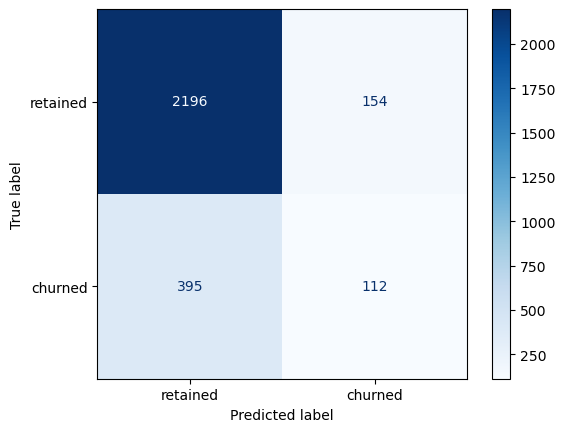

In [32]:
# Plot confusion matrix
cm = confusion_matrix(y_test, xgb_test_preds, labels=xgb_cv.classes_)

disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=['retained', 'churned'])

disp.plot(cmap=plt.cm.Blues) # type: ignore


##### **False Positive (FP) = 154,             False Negative (FN) = 395**

In this context:
- Positive = churned
- Negative = retained

A false positive means a user was predicted to churn but actually stayed — less harmful.

A false negative means a user was predicted to stay but actually churned — more harmful, as we miss the chance to retain them.

Since false negatives are costlier, we prioritize Recall, which measures how well we identify actual churners:

#### Recall = True Positives / (True Positives + False Negatives) = 112 / 112 + 395 ≈ 0.221 

-> (OUT OF ALL THE ACTUAL +VEs, model correctly predicted?)

Despite optimizing for recall, the model only identified ~22.1% of churners, indicating room for improvement in reducing false negatives.

### **Task 14. Feature importance**

Use the `plot_importance` function to inspect the most important features of your final model.

<Axes: title={'center': 'Feature Importance (Weight)'}, xlabel='Importance score', ylabel='Features'>

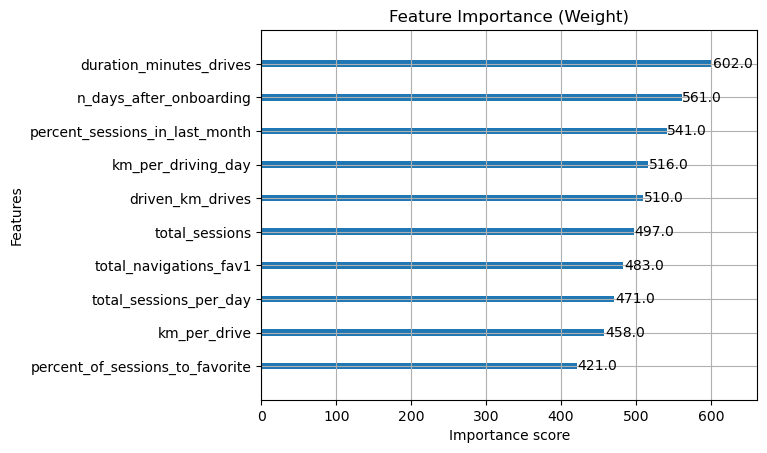

In [28]:
plot_importance(xgb_cv.best_estimator_, 
                importance_type='weight', 
                max_num_features=10, 
                title='Feature Importance (Weight)')


### **Task 15. Conclusion**

Now that you've built and tested your machine learning models, the next step is to share your findings with the Waze leadership team. Consider the following questions as you prepare to write your executive summary. Think about key points you may want to share with the team, and what information is most relevant to the user churn project.

**Questions:**

1. Would you recommend using this model for churn prediction? Why or why not?

> _It depends. What would the model be used for? If it's used to drive consequential business decisions, then no. The model is not a strong enough predictor, as made clear by its poor recall score. However, if the model is only being used to guide further exploratory efforts, then it can have value._

2. What tradeoff was made by splitting the data into training, validation, and test sets as opposed to just training and test sets?

> _Splitting the data three ways means that there is less data available to train the model than splitting just two ways. However, performing model selection on a separate validation set enables testing of the champion model by itself on the test set, which gives a better estimate of future performance than splitting the data two ways and selecting a champion model by performance on the test data._

3. What is the benefit of using a logistic regression model over an ensemble of tree-based models (like random forest or XGBoost) for classification tasks?

> _Logistic regression models are easier to interpret. Because they assign coefficients to predictor variables, they reveal not only which features factored most heavily into their final predictions, but also the directionality of the weight. In other words, they tell you if each feature is positively or negatively correlated with the target in the model's final prediction._

4. What is the benefit of using an ensemble of tree-based models like random forest or XGBoost over a logistic regression model for classification tasks?

> _Tree-based model ensembles are often better predictors. If the most important thing is the predictive power of the model, then tree-based modeling will usually win out against logistic regression (but not always!). They also require much less data cleaning and require fewer assumptions about the underlying distributions of their predictor variables, so they're easier to work with._

5. What could you do to improve this model?

> _New features could be engineered to try to generate better predictive signal, as they often do if you have domain knowledge. In the case of this model, the engineered features made up over half of the top 10 most-predictive features used by the model. It could also be helpful to reconstruct the model with different combinations of predictor variables to reduce noise from unpredictive features._

6. What additional features would you like to have to help improve the model?

> _It would be helpful to have drive-level information for each user (such as drive times, geographic locations, etc.). It would probably also be helpful to have more granular data to know how users interact with the app. For example, how often do they report or confirm road hazard alerts? Finally, it could be helpful to know the monthly count of unique starting and ending locations each driver inputs._
